In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
import tensorflow as tf
print(tf.test.gpu_device_name())
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True


In [2]:
import os
import pandas as pd

import tensorflow as tf
import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize

from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
import keras.callbacks as kcall
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

from Eve import Eve

%matplotlib inline

___

In [3]:
train_dir = 'data/Reinhard'

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

data/Reinhard 0
data/Reinhard/Invasive 3500
data/Reinhard/Normal 3500
data/Reinhard/InSitu 3500
data/Reinhard/Benign 3500


In [5]:
from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
    horizontal_flip=True,
    validation_split=0.25)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)


#target_size: Tuple of integers (height, width), default: (256, 256). 
#The dimensions to which all images found will be resized.
target_size = (256, 256)
#target_size = (height, width)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = target_size,       
        class_mode = 'categorical',
        batch_size=32,
        subset="training",
        shuffle = True)

validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = target_size,        
        class_mode = 'categorical',
        batch_size=32,
        subset = "validation",
        shuffle = True)

Found 10500 images belonging to 4 classes.
Found 3500 images belonging to 4 classes.


In [6]:
## Intilizing variables
output_classes = 4
batch_size = 32 
epochs = 30

sgd_opt = SGD(lr=1E-2, decay=1E-4, momentum=0.9, nesterov=True)
adam_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1E-4)
eve_opt = Eve(lr=1E-4, decay=1E-4, beta_1=0.9, beta_2=0.999, beta_3=0.999, small_k=0.1, big_K=10, epsilon=1e-08)

resume_model = False
xception_weights = 'pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [30]:
model = Sequential()

model.add(Xception(weights = xception_weights, include_top=False, pooling = 'avg'))

model.add(Dense(units=output_classes, activation='softmax'))

model.layers[0].trainable = True

model.compile(loss = 'categorical_crossentropy',
              optimizer = adam_opt,
              metrics = ['accuracy'])

In [8]:
for i, layer in enumerate(model.layers):
    print('Layer: ',i+1,' Name: ', layer.name)

Layer:  1  Name:  xception
Layer:  2  Name:  dense_1


In [9]:
num_train_samples= len(train_generator.filenames)
num_train_samples

10500

In [10]:
num_val_samples= len(validation_generator.filenames)
num_val_samples

3500

In [11]:
history = model.fit_generator(train_generator,
        steps_per_epoch =int(np.ceil(num_train_samples * 1.0 / batch_size)),
        epochs = epochs,
        validation_data = validation_generator,
        validation_steps=int(np.ceil(num_val_samples * 1.0 / batch_size)))

Epoch 1/30
329/329 [==============================] - 7939s 24s/step - loss: 0.5174 - acc: 0.8002 - val_loss: 1.0566 - val_acc: 0.6834
Epoch 2/30
329/329 [==============================] - 7912s 24s/step - loss: 0.1616 - acc: 0.9440 - val_loss: 1.4032 - val_acc: 0.6760
Epoch 3/30
329/329 [==============================] - 7911s 24s/step - loss: 0.0898 - acc: 0.9703 - val_loss: 1.0667 - val_acc: 0.7209
Epoch 4/30
329/329 [==============================] - 7912s 24s/step - loss: 0.0523 - acc: 0.9835 - val_loss: 1.2765 - val_acc: 0.7069
Epoch 5/30
329/329 [==============================] - 7914s 24s/step - loss: 0.0545 - acc: 0.9821 - val_loss: 1.3942 - val_acc: 0.6954
Epoch 6/30
329/329 [==============================] - 7916s 24s/step - loss: 0.0468 - acc: 0.9851 - val_loss: 1.3783 - val_acc: 0.7134
Epoch 7/30
329/329 [==============================] - 7922s 24s/step - loss: 0.0394 - acc: 0.9884 - val_loss: 1.4650 - val_acc: 0.7137
Epoch 8/30
329/329 [==============================] - 8

In [12]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [13]:
history.history["val_loss"]

[1.0566438899721418,
 1.4031754519598825,
 1.066743425130844,
 1.2764606445857456,
 1.3942276503699167,
 1.3783026716368538,
 1.4650260722296577,
 2.1156473944527763,
 1.6840087736674718,
 1.7667802663530623,
 1.7453884555271693,
 1.5972329416275024,
 1.6130417496817453,
 1.7571122065952847,
 1.645358428137643,
 1.9050105142593383,
 1.6904488743373325,
 2.006306636695351,
 2.4169225792203632,
 2.0089629633767263,
 1.8170504918779646,
 1.793784586225237,
 1.8935812012808664,
 1.7607953030722483,
 1.7639131411143711,
 1.5665155213986124,
 1.8774114873068672,
 2.0803678899492537,
 2.038608517101833,
 2.0833340470450263]

In [14]:
history.history["val_acc"]

[0.6834285714285714,
 0.676,
 0.7208571429252625,
 0.7068571427890232,
 0.6954285714285714,
 0.7134285713604518,
 0.7137142856461661,
 0.647428571496691,
 0.7040000000681196,
 0.6814285714285714,
 0.6777142857142857,
 0.7048571428571428,
 0.7057142857142857,
 0.687428571496691,
 0.6842857143538339,
 0.7040000000681196,
 0.6985714285714286,
 0.6911428571428572,
 0.6448571427890233,
 0.685428571496691,
 0.690571428503309,
 0.7005714285714286,
 0.6791428572109768,
 0.7005714285714286,
 0.6717142856461661,
 0.6994285714285714,
 0.6939999999318804,
 0.6802857142857143,
 0.6860000000681196,
 0.66]

In [15]:
history.history["loss"]

[0.5166216211091904,
 0.15935890294256663,
 0.08947373077131453,
 0.05243352468098913,
 0.05245710775610946,
 0.04284924229873078,
 0.03770879396583353,
 0.02671747126323836,
 0.026774403420409987,
 0.027455622034413475,
 0.01837549712473438,
 0.023078675150516488,
 0.018402809307422666,
 0.01757166597575304,
 0.01563813013743077,
 0.013263526187233981,
 0.01263973253089491,
 0.013204891316614868,
 0.015513372134106855,
 0.019023620013214115,
 0.013502916872989209,
 0.010272954180936463,
 0.009262417237052605,
 0.013277070144191385,
 0.009416111457427698,
 0.011142829813506632,
 0.00556228731368624,
 0.005526956313212092,
 0.0055660004451471784,
 0.011607007962895469]

In [16]:
history.history["acc"]

[0.800952380952381,
 0.9444761904761905,
 0.9701904761904762,
 0.9834285714285714,
 0.9827619047619047,
 0.9863809523809524,
 0.9890476190476191,
 0.9906666666666667,
 0.9923809523809524,
 0.9915238095238095,
 0.9940952380952381,
 0.9927619047619047,
 0.9938095238095238,
 0.9949523809523809,
 0.9958095238095238,
 0.9953333333333333,
 0.9962857142857143,
 0.996,
 0.996,
 0.9941904761904762,
 0.996,
 0.9966666666666667,
 0.9968571428571429,
 0.9954285714285714,
 0.9971428571428571,
 0.9965714285714286,
 0.9985714285714286,
 0.9985714285714286,
 0.9984761904761905,
 0.9961904761904762]

In [17]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])

Test Score:  2.058975793123245
Test Accuracy:  0.66125


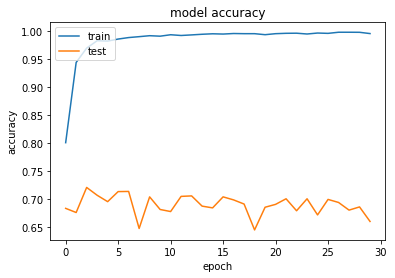

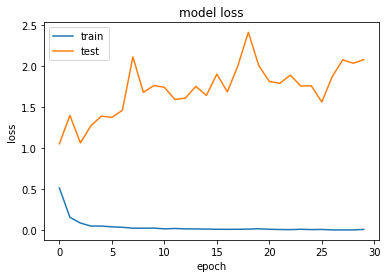

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

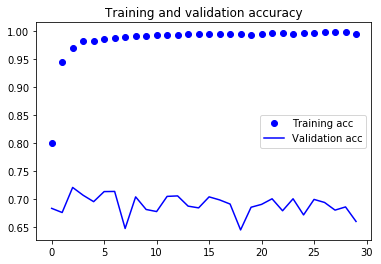

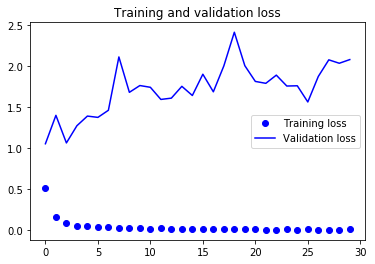

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


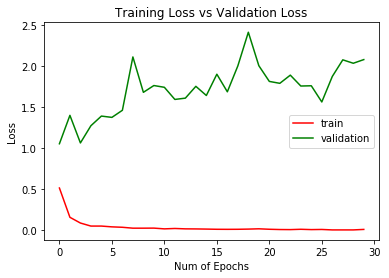

In [20]:
import numpy as np
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.show()

In [21]:
filename = validation_generator.filenames
truth = validation_generator.classes
label = validation_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

In [22]:
predicts = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

110/109 [==============================] - 995s 9s/step
No of errors = 2601/3500


/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Confusion Matrix
[[ 95 371 179 230]
 [ 84 378 156 257]
 [ 95 382 176 222]
 [ 90 367 168 250]]


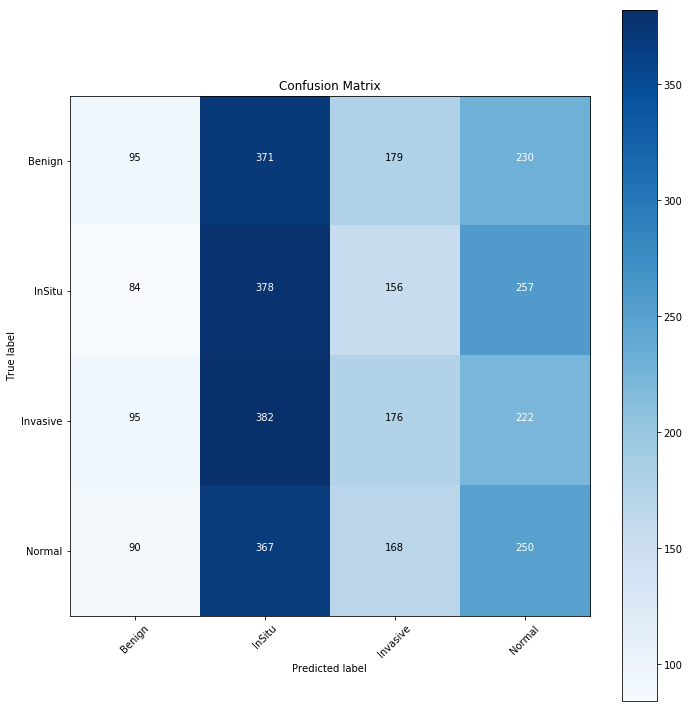

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [24]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score 

#and reports metrics with classification_report method
def predict_and_report(gen, model):
    y_true = []
    y_pred = []
    gen.reset()
    for img, label in gen:
        #get true labels for batch and store them
        y_true.extend([int(z[1]) for z in label])
        #Get predictions as probabilities
        batch_pred = model.predict_on_batch(img)
        #turn probabilities to class labels and store
        batch_pred = np.argmax(batch_pred, axis=1)
        y_pred.extend(batch_pred)
        #break loop
        if gen.batch_index == 0:
            break
            
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Area Under the Receiver Operating Characteristic Curve:', roc_auc_score(y_true, y_pred)) #Area under the curve
    print(classification_report(y_true, y_pred))

In [25]:
predict_and_report(train_generator, model)

Accuracy: 0.4997142857142857
Area Under the Receiver Operating Characteristic Curve: 0.3333968253968254
             precision    recall  f1-score   support

          0       1.00      0.33      0.50      7875
          1       1.00      1.00      1.00      2625
          2       0.00      0.00      0.00         0
          3       0.00      0.00      0.00         0

avg / total       1.00      0.50      0.62     10500



/home/sara/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [26]:
predict_and_report(validation_generator, model)

Accuracy: 0.3222857142857143
Area Under the Receiver Operating Characteristic Curve: 0.28616141496598635
             precision    recall  f1-score   support

          0       0.95      0.13      0.23      2625
          1       0.54      0.90      0.67       875
          2       0.00      0.00      0.00         0
          3       0.00      0.00      0.00         0

avg / total       0.84      0.32      0.34      3500



/home/sara/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [27]:
best_train_acc = max(history.history['acc'])
best_train_acc

0.9985714285714286

In [32]:
best_train_acc = max(history.history['val_acc'])
best_train_acc

0.7208571429252625

In [28]:
last_train_acc = history.history['acc'][-1]
last_train_acc

0.9961904761904762

In [29]:
model.save('models/1.Xception-Adam-Model.h5')
model.save_weights('models/1.Xception-Adam-Weights.h5')